In [1]:
import torch.nn as nn
import torch 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# NN Classification (Perceptron) : Noun/ Not-Noun

## Data preparation

### Load data: NOUN, ADJ, and both

In [2]:
nouns = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv', index_col=0).drop(columns=['gender', 'number'])
nouns['noun'] = 1
nouns['verb'] = 0
nouns['adj'] = 0

verbs = pd.read_csv('../Data/FlauBERT_WE/all_verb_we.csv', index_col=0)
verbs['noun'] = 0
verbs['verb'] = 1
verbs['adj'] = 0

adjs = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv', index_col=0).drop(columns=['gender', 'number'])
adjs['noun'] = 0
adjs['verb'] = 0
adjs['adj'] = 1


data = pd.concat([nouns, adjs, verbs])
data = data.sample(frac=1)

normalized_data = (data - data.min())/(data.max() - data.min()) 

In [74]:
# target : gender
Y_N = np.asarray(normalized_data.noun)
Y_V = np.asarray(normalized_data.verb)
Y_A = np.asarray(normalized_data.adj)

# features : word embeddings dimensions
X = np.asarray(normalized_data.iloc[:, :512])

# split data into train and test sets
X_N_train, X_N_test, Y_N_train, Y_N_test = train_test_split(X, Y_N, test_size=0.2, random_state=42)
X_A_train, X_A_test, Y_A_train, Y_A_test = train_test_split(X, Y_A, test_size=0.2, random_state=42)
X_V_train, X_V_test, Y_V_train, Y_V_test = train_test_split(X, Y_V, test_size=0.2, random_state=42)

names = ['Noun vs Not Noun', 'Adj vs Not Adj', 'Verb vs not Verb']

In [75]:
train_features = [X_N_train, X_A_train, X_V_train]
test_features = [X_N_test, X_A_test, X_V_test]
train_targets = [Y_N_train, Y_A_train, Y_V_train]
test_targets = [Y_N_test, Y_A_test, Y_V_test]

### Tensors

In [76]:
# convert to tensors
train_features = [torch.tensor(x).float() for x in train_features]
test_features = [torch.tensor(x).float() for x in test_features]
train_targets = [torch.tensor(x).long() for x in train_targets]
test_targets = [torch.tensor(x).long() for x in test_targets]

In [77]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_features, train_targets)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_features, test_targets)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

### NN definition

In [78]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer (2 classes)
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [79]:
nb_epochs = 100

In [80]:
# train the models 
for i in range(3):
    print("* Training model ", names[i])
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  Noun vs Not Noun
--Epoch  0  Loss :  0.6224977970123291
--Epoch  10  Loss :  0.5836396217346191
--Epoch  20  Loss :  0.42178863286972046
--Epoch  30  Loss :  0.47646814584732056
--Epoch  40  Loss :  0.6465696096420288
--Epoch  50  Loss :  0.5974539518356323
--Epoch  60  Loss :  0.7030676603317261
--Epoch  70  Loss :  0.4193163812160492
--Epoch  80  Loss :  0.6199532747268677
--Epoch  90  Loss :  0.47942134737968445
* Training model  Adj vs Not Adj
--Epoch  0  Loss :  0.7506719827651978
--Epoch  10  Loss :  0.500761866569519
--Epoch  20  Loss :  0.37576165795326233
--Epoch  30  Loss :  0.6257616877555847
--Epoch  40  Loss :  0.5632616281509399
--Epoch  50  Loss :  0.37576162815093994
--Epoch  60  Loss :  0.37586602568626404
--Epoch  70  Loss :  0.47269904613494873
--Epoch  80  Loss :  0.522280216217041
--Epoch  90  Loss :  0.5838065147399902
* Training model  Verb vs not Verb
--Epoch  0  Loss :  0.618535041809082
--Epoch  10  Loss :  0.42603567242622375
--Epoch  20  Lo

Model  Noun vs Not Noun 
 Accuracy :  0.7773095077545515
 Precision :  0.7202159762382507
 Recall :  0.8126428127288818
 F1 score :  0.7636428475379944
Confusion matrix : 


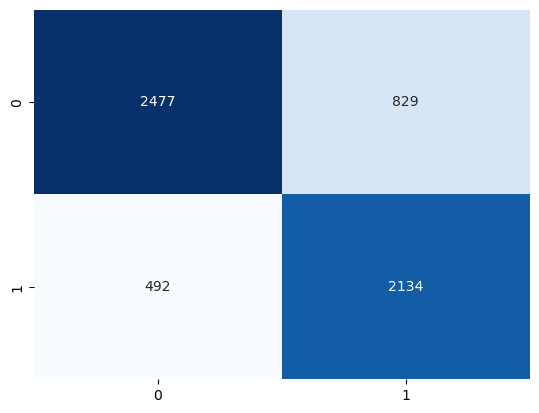

Model  Adj vs Not Adj 
 Accuracy :  0.7929871881321645
 Precision :  0.5193049907684326
 Recall :  0.21554486453533173
 F1 score :  0.3046432435512543
Confusion matrix : 


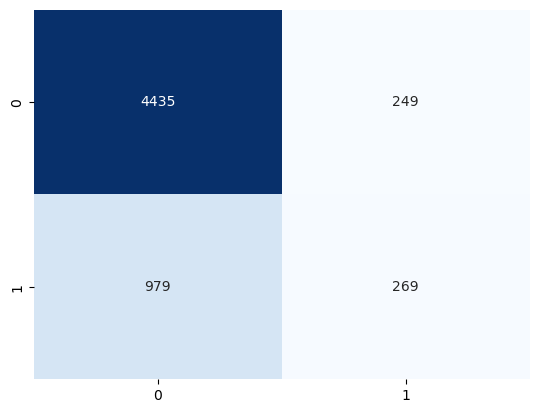

Model  Verb vs not Verb 
 Accuracy :  0.7887727579231288
 Precision :  0.8744186162948608
 Recall :  0.4567541182041168
 F1 score :  0.6000638604164124
Confusion matrix : 


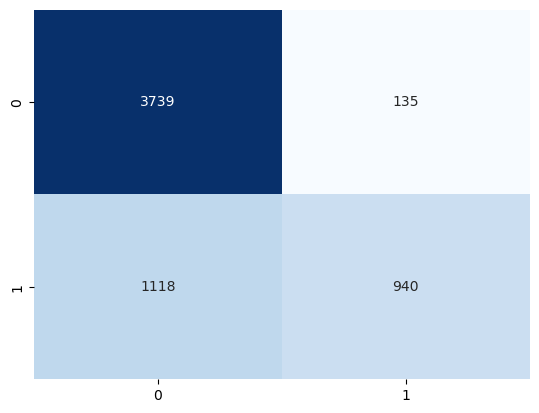

In [81]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[int(t), int(p)] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", names[i], "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.show()

In [128]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy()[0] for i in range(3)]

In [151]:
print(weights[0].shape)

(512,)


In [130]:
# store the weights in a pandas dataframe


weights_dict = {
    'Noun': weights[0],
    'Adj': weights[1],
    'Verb': weights[2]
}
weight_df = pd.DataFrame.from_dict(weights_dict, orient='index')

weight_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
Noun,0.149936,0.598463,0.533892,-0.332718,0.496957,0.188776,0.343081,0.382977,-0.226677,-0.688473,...,-0.042238,-0.095188,0.012683,0.004088,-0.357492,-0.045676,-0.385591,-0.315521,-0.409010,0.123502
Adj,-0.140925,-0.043848,-0.173868,0.154612,-0.483496,0.048321,-0.016861,-0.192045,0.030146,0.355934,...,-0.288227,-0.056553,-0.089689,-0.163437,-0.057995,-0.081075,-0.103700,-0.296131,0.166126,-0.030992
Verb,0.239808,-0.407190,-0.422331,-0.293532,0.014198,0.236477,-0.136263,0.218399,-0.283480,-0.088395,...,0.103206,-0.047892,-0.525010,0.251328,0.369132,0.181145,0.986733,0.712210,-0.122580,-0.213110


Noun highest weights:

In [139]:
pd.DataFrame(weight_df.loc['Noun'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,275
1,409
2,132
3,378
4,78
5,345
6,229
7,387
8,465
9,260


Adjective highest weights:

In [140]:
pd.DataFrame(weight_df.loc['Adj'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,158
1,315
2,439
3,117
4,499
5,346
6,260
7,429
8,4
9,310


Verbs highest weights:

In [141]:
pd.DataFrame(weight_df.loc['Verb'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,192
1,310
2,378
3,429
4,480
5,56
6,508
7,499
8,311
9,182


# Unique words only

Filter out non-unique words:

In [167]:
word, count = np.unique(normalized_data.index, return_counts=True)
unique_words = [x[0] for x in list(filter(lambda x: x[1] == 1, zip(word, count)))]

In [168]:
unique_norm = normalized_data[normalized_data.index.isin(unique_words)]

In [169]:
unique_norm = unique_norm.sample(frac=1)

In [170]:
# target
Y_N_un = np.asarray(unique_norm.noun)
Y_V_un = np.asarray(unique_norm.verb)
Y_A_un = np.asarray(unique_norm.adj)

# features : word embeddings dimensions
X_un = np.asarray(unique_norm.iloc[:, :512])

# split data into train and test sets
X_N_train, X_N_test, Y_N_train, Y_N_test = train_test_split(X_un, Y_N_un, test_size=0.2, random_state=42)
X_A_train, X_A_test, Y_A_train, Y_A_test = train_test_split(X_un, Y_A_un, test_size=0.2, random_state=42)
X_V_train, X_V_test, Y_V_train, Y_V_test = train_test_split(X_un, Y_V_un, test_size=0.2, random_state=42)

names_un = ['Noun vs Not Noun (unique words only)', 'Adj vs Not Adj (unique words only)', 'Verb vs not Verb (unique words only)']

In [171]:
train_features = [X_N_train, X_A_train, X_V_train]
test_features = [X_N_test, X_A_test, X_V_test]
train_targets = [Y_N_train, Y_A_train, Y_V_train]
test_targets = [Y_N_test, Y_A_test, Y_V_test]

In [172]:
# convert to tensors
train_features = [torch.tensor(x).float() for x in train_features]
test_features = [torch.tensor(x).float() for x in test_features]
train_targets = [torch.tensor(x).long() for x in train_targets]
test_targets = [torch.tensor(x).long() for x in test_targets]

In [173]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_features, train_targets)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_features, test_targets)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

In [182]:
NNlist_un = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer (2 classes)
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist_un.append([model, loss_fn, optimizer])

In [183]:
# train the models 
for i in range(3):
    print("* Training model ", names_un[i])
    model, loss_fn, optimizer = NNlist_un[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  Noun vs Not Noun (unique words only)
--Epoch  0  Loss :  0.5172184705734253
--Epoch  10  Loss :  0.451754093170166
--Epoch  20  Loss :  0.37441790103912354
--Epoch  30  Loss :  0.31880781054496765
--Epoch  40  Loss :  0.42292386293411255
--Epoch  50  Loss :  0.32287299633026123
--Epoch  60  Loss :  0.4744892120361328
--Epoch  70  Loss :  0.4368833601474762
--Epoch  80  Loss :  0.31645673513412476
--Epoch  90  Loss :  0.5297096967697144
* Training model  Adj vs Not Adj (unique words only)
--Epoch  0  Loss :  0.5132862329483032
--Epoch  10  Loss :  0.5132623910903931
--Epoch  20  Loss :  0.3132619559764862
--Epoch  30  Loss :  0.3132617473602295
--Epoch  40  Loss :  0.41326165199279785
--Epoch  50  Loss :  0.3132616877555847
--Epoch  60  Loss :  0.4132617115974426
--Epoch  70  Loss :  0.3132616877555847
--Epoch  80  Loss :  0.41326165199279785
--Epoch  90  Loss :  0.3132616877555847
* Training model  Verb vs not Verb (unique words only)
--Epoch  0  Loss :  0.45214456319

Model  Noun vs Not Noun (unique words only) 
 Accuracy :  0.9388994307400379
 Precision :  0.9521963596343994
 Recall :  0.9442664980888367
 F1 score :  0.9482148289680481
Confusion matrix : 


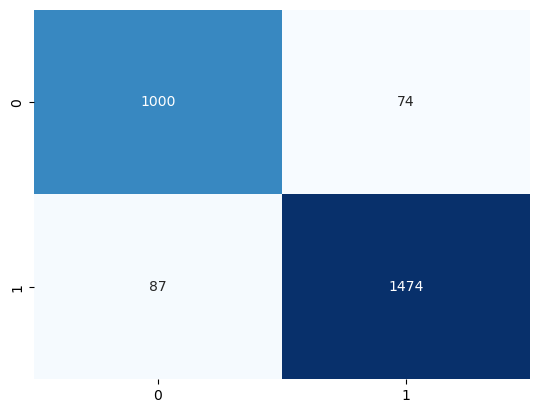

Model  Adj vs Not Adj (unique words only) 
 Accuracy :  0.9316888045540797
 Precision :  nan
 Recall :  0.0
 F1 score :  nan
Confusion matrix : 


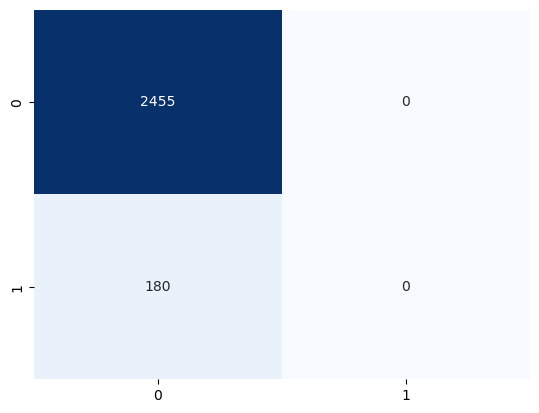

Model  Verb vs not Verb (unique words only) 
 Accuracy :  0.967741935483871
 Precision :  0.9798339009284973
 Recall :  0.9239373803138733
 F1 score :  0.9510650038719177
Confusion matrix : 


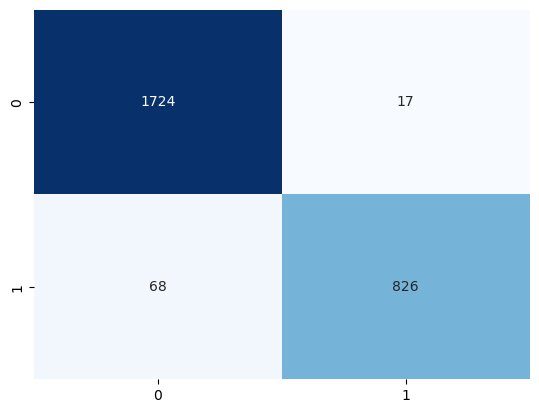

In [184]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist_un[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist_un[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[int(t), int(p)] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", names_un[i], "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.show()

Weights for unique words:

In [185]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist_un[i][0][0].weight.data.numpy()[0] for i in range(3)]

In [186]:
# store the weights in a pandas dataframe


weights_dict = {
    'Noun': weights[0],
    'Adj': weights[1],
    'Verb': weights[2]
}
weight_df = pd.DataFrame.from_dict(weights_dict, orient='index')

weight_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
Noun,-0.180454,0.643335,0.396531,-0.295674,0.695562,-0.188022,0.219599,0.002521,0.062909,-0.588619,...,0.249292,0.161098,-0.029207,0.025964,-0.182683,0.188732,-0.778827,-0.348599,-0.640534,0.252175
Adj,0.047830,0.022359,0.020490,0.061702,0.037512,0.015431,0.065770,0.011578,0.036973,0.074561,...,0.013905,0.028858,0.015241,0.002146,0.065080,0.044383,0.020371,0.065825,0.033098,-0.009339
Verb,0.267867,-0.736796,-0.633860,-0.306305,0.407020,0.556875,-0.659056,-0.101476,-0.257852,0.071684,...,-0.085225,0.147153,0.258065,0.183200,-0.021882,-0.014650,1.003855,1.158595,0.168167,-0.402417


Noun's weights:

In [187]:
pd.DataFrame(weight_df.loc['Noun'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,275
1,378
2,409
3,78
4,465
5,305
6,480
7,229
8,37
9,192


Adjective weights:

In [188]:
pd.DataFrame(weight_df.loc['Adj'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,187
1,99
2,433
3,250
4,100
5,222
6,209
7,304
8,9
9,169


In [189]:
pd.DataFrame(weight_df.loc['Verb'].apply(abs).sort_values(ascending=False)[:10].index)

,0
0,192
1,378
2,282
3,310
4,393
5,480
6,89
7,305
8,429
9,154
